In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import io

from statsmodels.tsa.stattools import adfuller

plt.style.use('ggplot')

In [2]:
with pd.HDFStore('./large_files/data_20240312.h5', mode='r') as store:
    df_ = store.get('data/cl')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Index: 2529084 entries, 525 to 5683617
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 212.2+ MB


In [3]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022])]
df = df.loc[df.index.day_of_week == 2]

In [4]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    data = {
        'adf': result[0],
        'p-value': result[1],
    }
    for key, value in result[4].items():
        data[f'critical {key}'] = value

    return data

def z_score(chunk):
    return (chunk[-1] - chunk.mean()) / chunk.std()

In [5]:
results = []
acfs = []
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day = df_day[(df_day.index.hour >= 10) & (df_day.index.hour < 12)]
    returns = df_day['close'].pct_change().iloc[1:]
    adf_result = adf_test(returns)
    adf_result['day'] = day.strftime('%Y%m%d')

    acf = sm.tsa.acf(returns, nlags=30)

    results.append(adf_result)
    acfs.append(acf)

df_result = pd.DataFrame(results)
acfs = np.array(acfs)

In [6]:
print(np.std(acfs, axis=0))
acf = np.mean(acfs, 0)

[0.         0.09628103 0.09353177 0.09071423 0.08714182 0.09740904
 0.09163296 0.08087544 0.08882986 0.09346251 0.09334671 0.09662095
 0.08842809 0.0860702  0.08646126 0.08887663 0.08956481 0.07713777
 0.08731    0.07589837 0.08128543 0.09082154 0.0720483  0.08080943
 0.07401035 0.07421978 0.0775756  0.08032809 0.07134155 0.08168722
 0.07803761]


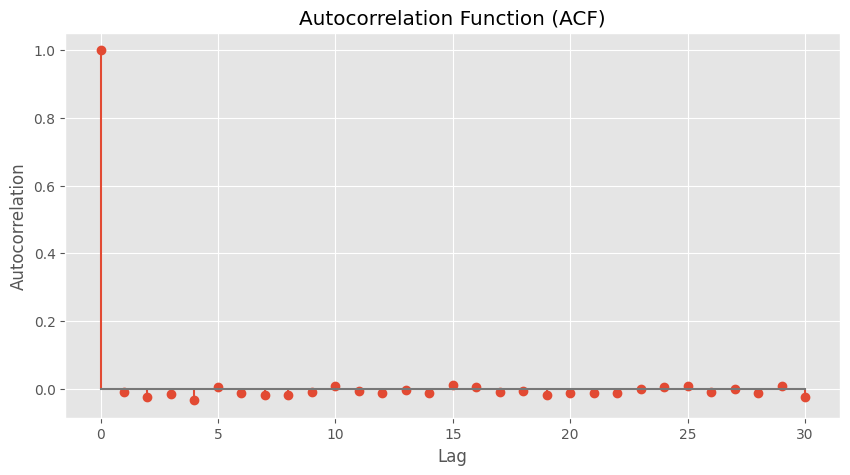

In [7]:
plt.figure(figsize=(10, 5))
plt.stem(acf)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [8]:
acf

array([ 1.00000000e+00, -9.46058639e-03, -2.53204449e-02, -1.47756321e-02,
       -3.44451104e-02,  4.08990344e-03, -1.27276625e-02, -2.03742910e-02,
       -1.90864296e-02, -9.84596194e-03,  6.83593355e-03, -8.60045541e-03,
       -1.16424149e-02, -4.92664170e-03, -1.36512290e-02,  9.89003313e-03,
        3.94895735e-03, -1.13226544e-02, -7.52301658e-03, -2.00635133e-02,
       -1.30752714e-02, -1.39362497e-02, -1.43415920e-02, -6.80547909e-04,
        4.27447429e-03,  8.96168852e-03, -1.06546082e-02, -8.60306770e-04,
       -1.24234342e-02,  7.11804968e-03, -2.34473184e-02])

In [9]:
results = []
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    close = df_day.close
    rolled = close.rolling(window=30).apply(z_score).dropna()
    adf_result = adf_test(rolled)
    adf_result['day'] = day.strftime('%Y%m%d')
    results.append(adf_result)

df_result = pd.DataFrame(results)

print(f'''
    Stationary: {df_result[df_result["p-value"] < 0.05].shape[0]}
    Non-Stationary: {df_result[df_result["p-value"] >= 0.05].shape[0]}
''')

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13


    Stationary: 62
    Non-Stationary: 42



/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()
/tmp/ipykernel_11483/4251432677.py:13

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


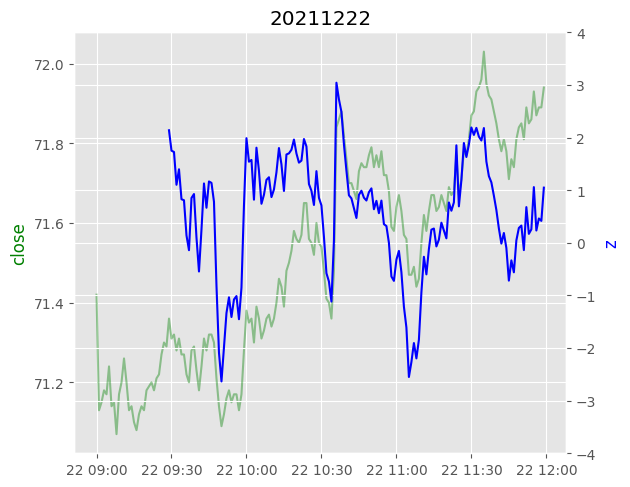

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


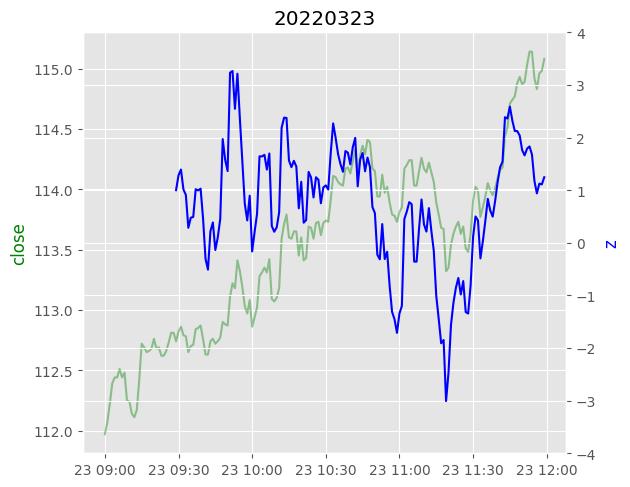

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


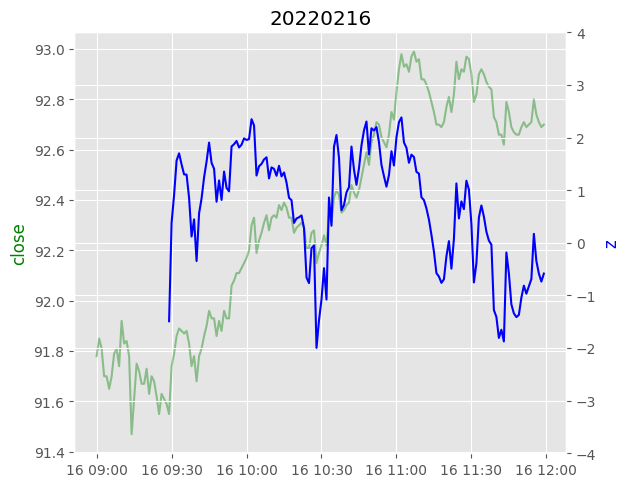

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


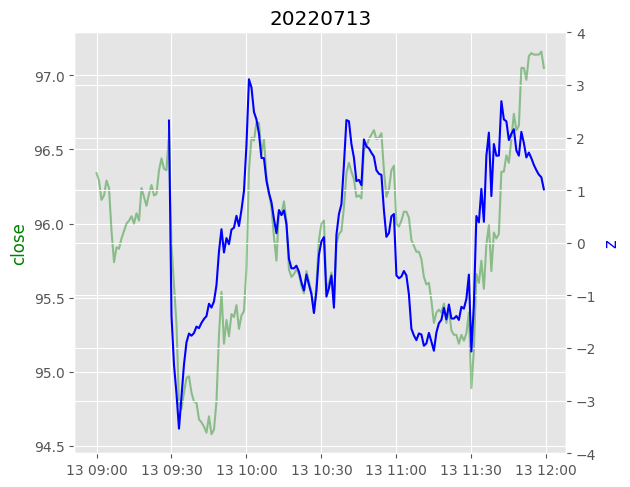

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


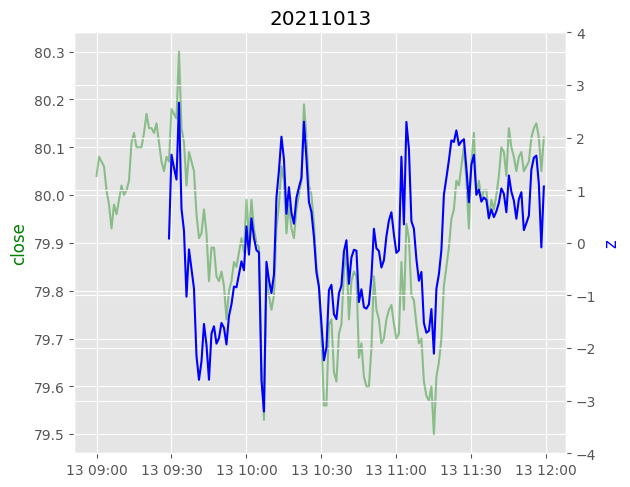

In [10]:
df_stat = df_result[df_result["p-value"] < 0.05]

df_stat = df_stat.sample(5)
for idx, row in df_stat.iterrows():
    day = row['day']
    df_day = df[df['datetime'].dt.strftime('%Y%m%d') == day]

    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    close = df_day.close
    rolled = close.rolling(window=30).apply(z_score)

    fig, ax1 = plt.subplots()

    ax1.plot(close.index, close, 'g-',  alpha=0.4)
    ax1.set_ylabel('close', color='g')

    ax2 = ax1.twinx()
    ax2.set_ylim([-4, 4])
    ax2.plot(close.index, rolled, 'b-',)
    ax2.set_ylabel('z', color='b')

    plt.tight_layout()
    plt.title(day)
    plt.show()

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


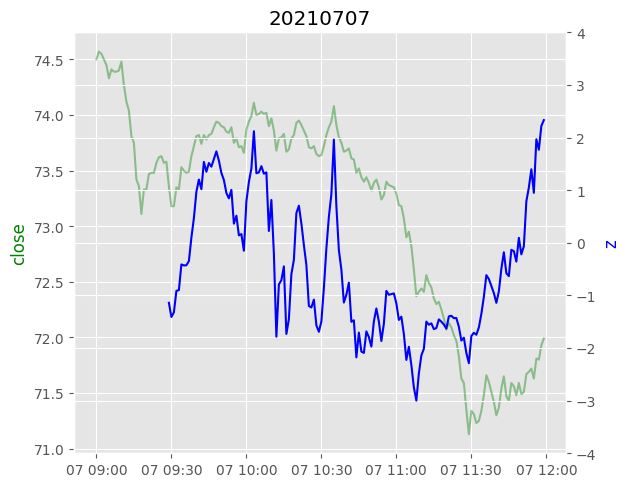

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


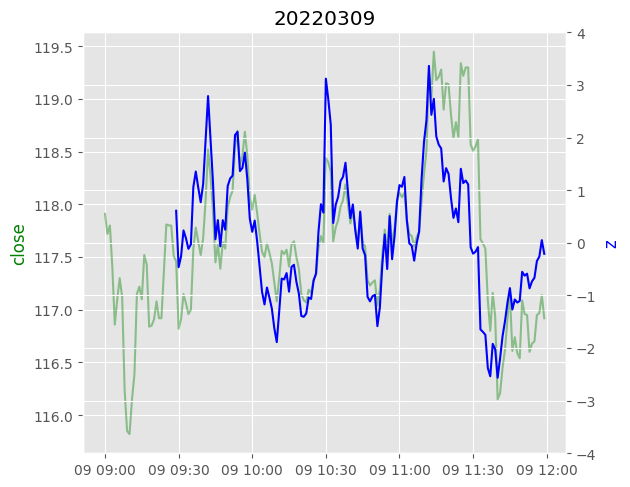

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


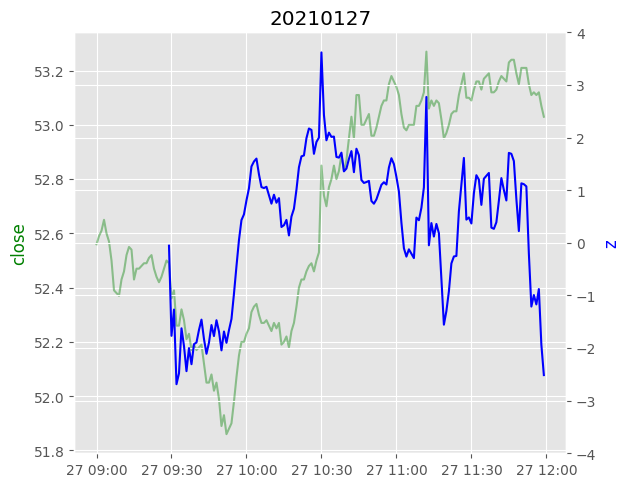

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


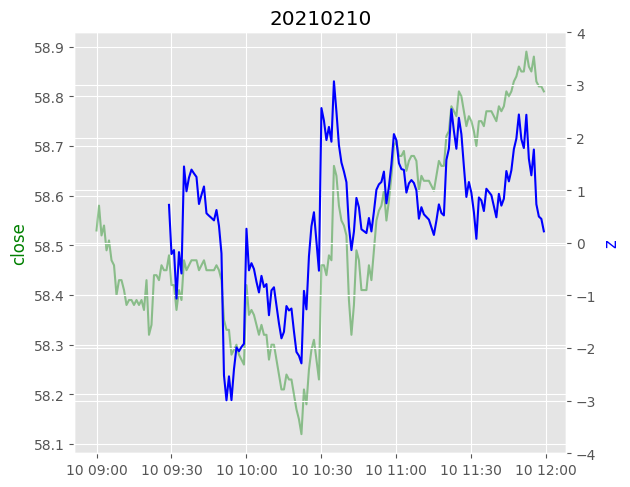

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


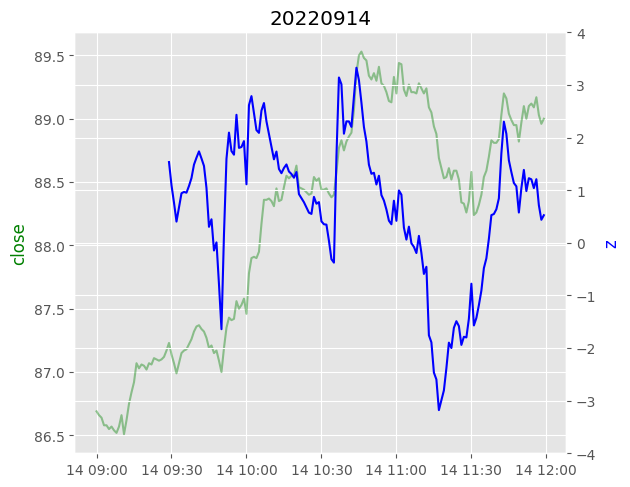

In [11]:
df_non_stat = df_result[df_result["p-value"] >= 0.05].sample(5)
for idx, row in df_non_stat.iterrows():
    day = row['day']
    df_day = df[df['datetime'].dt.strftime('%Y%m%d') == day]

    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    close = df_day.close
    rolled = close.rolling(window=30).apply(z_score)

    fig, ax1 = plt.subplots()

    ax1.plot(close.index, close, 'g-',  alpha=0.4)
    ax1.set_ylabel('close', color='g')

    ax2 = ax1.twinx()
    ax2.set_ylim([-4, 4])
    ax2.plot(close.index, rolled, 'b-',)
    ax2.set_ylabel('z', color='b')

    plt.tight_layout()
    plt.title(day)
    plt.show()

/tmp/ipykernel_11483/4251432677.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (chunk[-1] - chunk.mean()) / chunk.std()


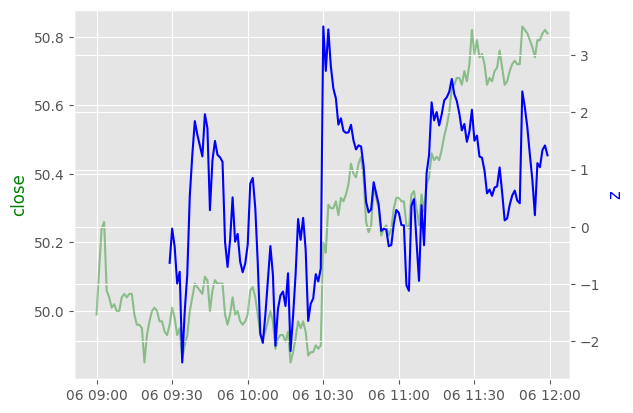

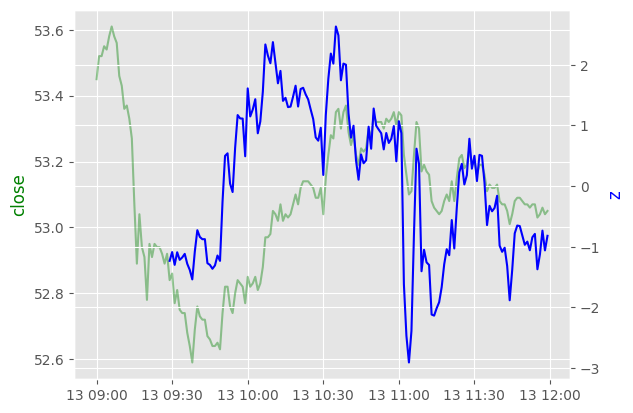

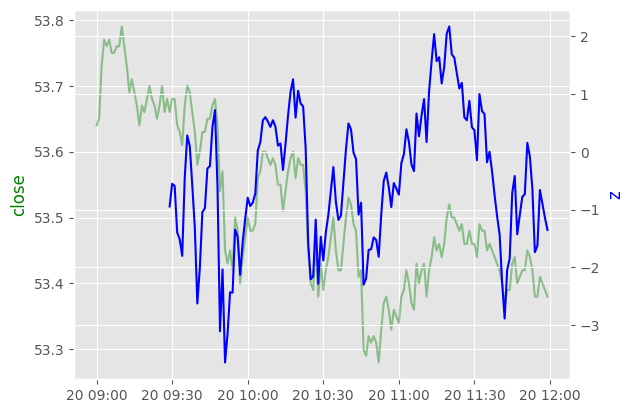

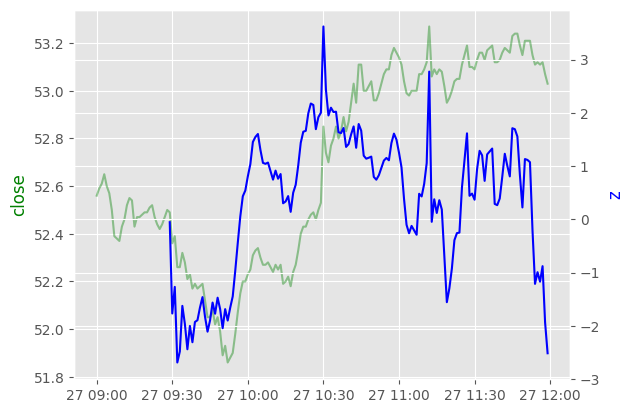

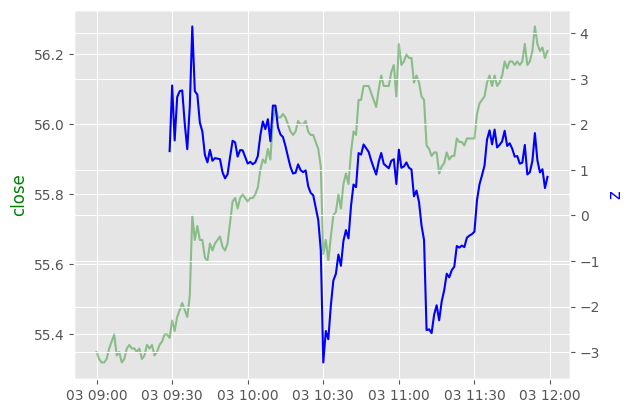

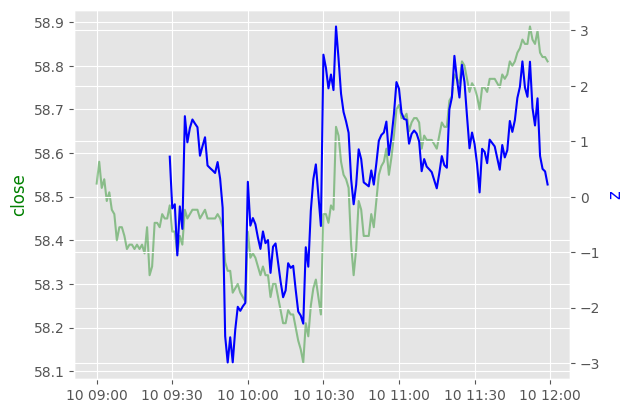

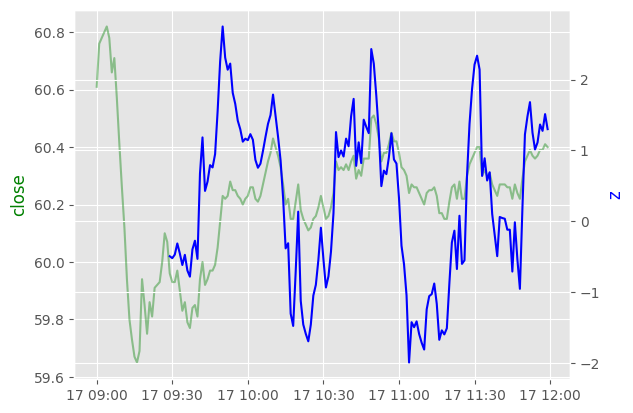

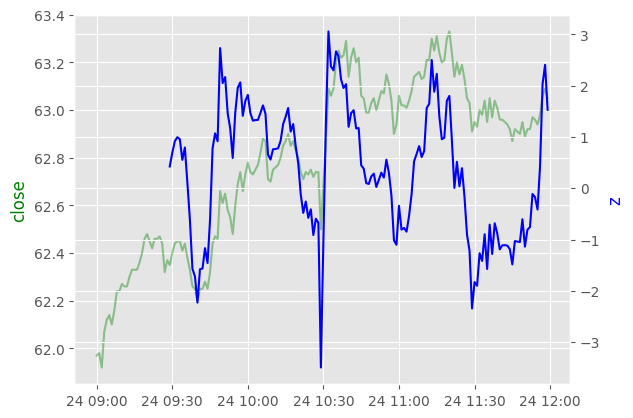

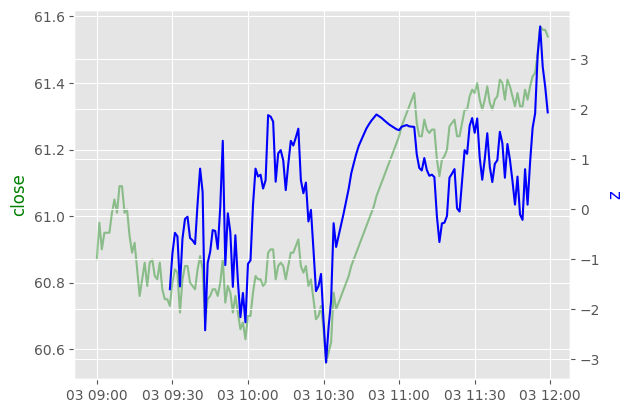

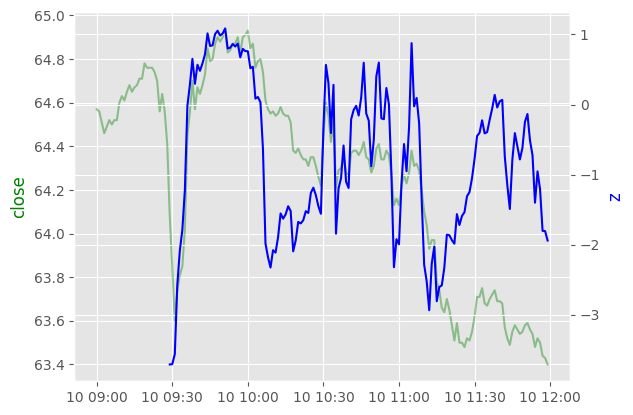

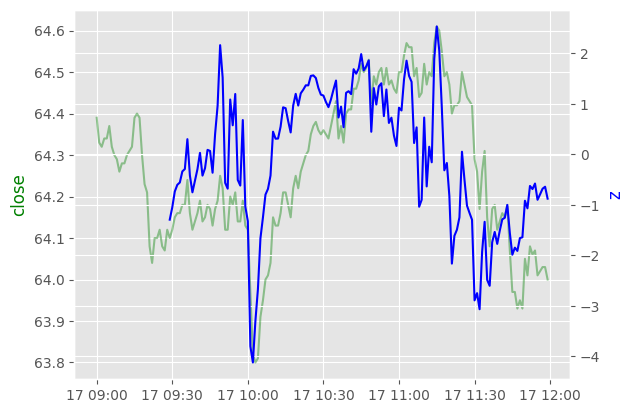

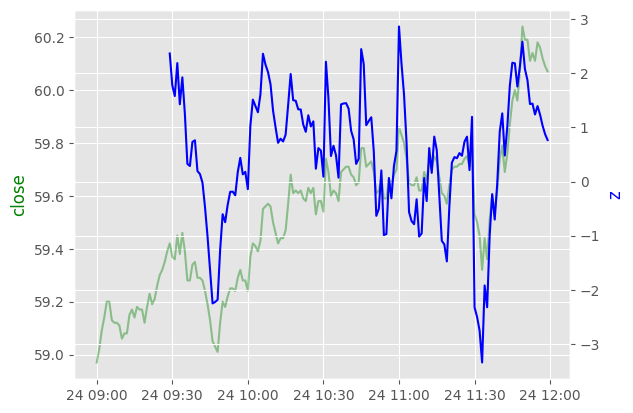

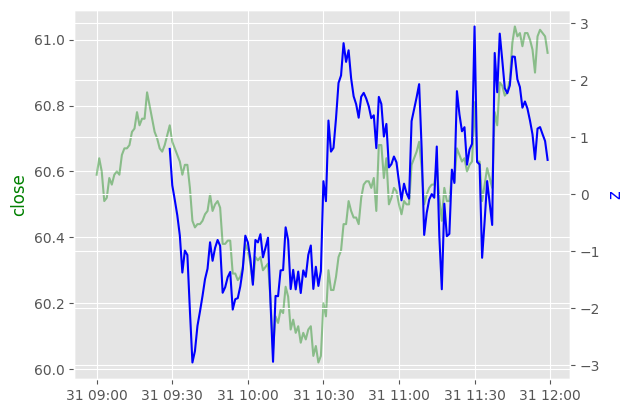

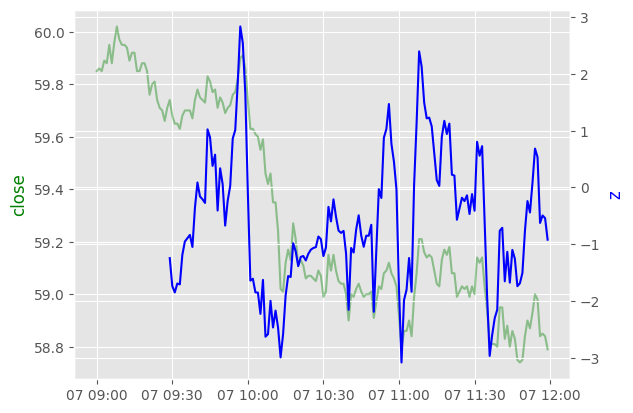

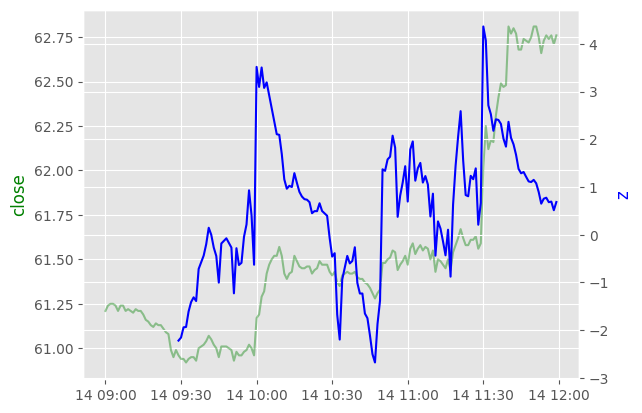

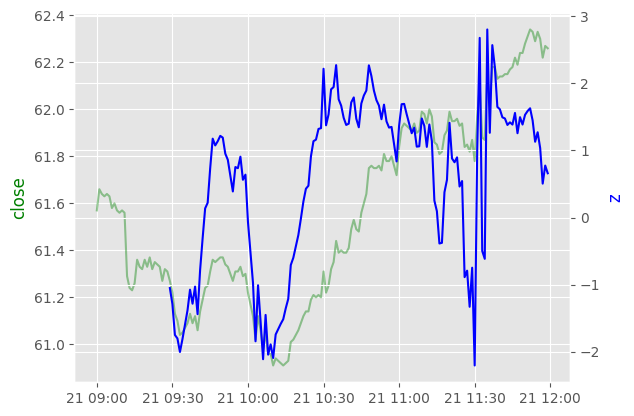

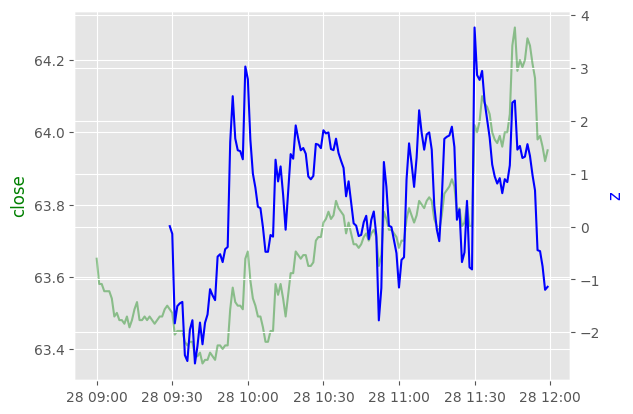

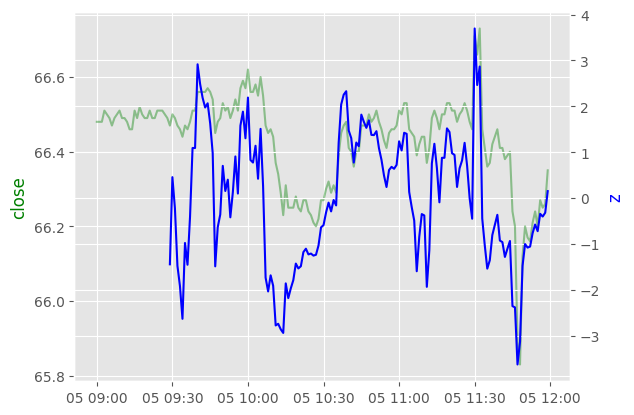

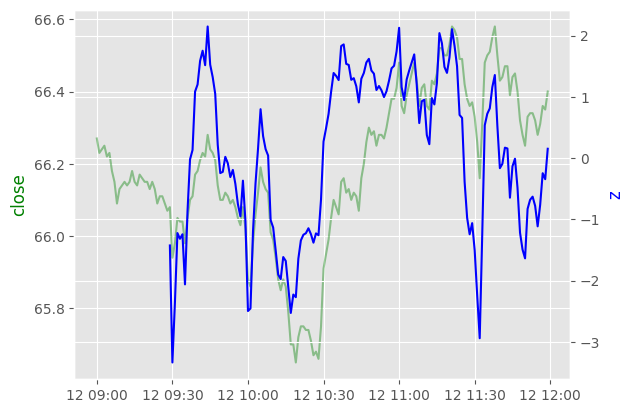

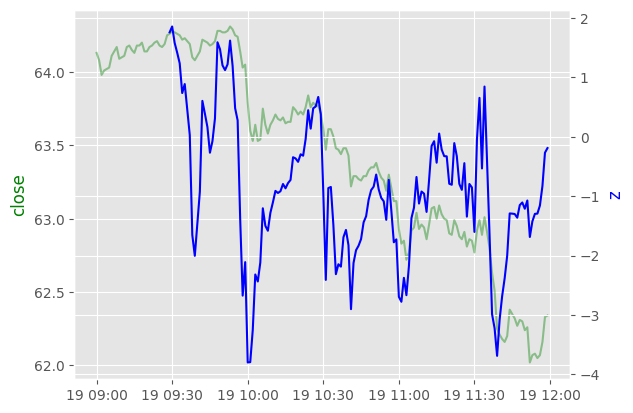

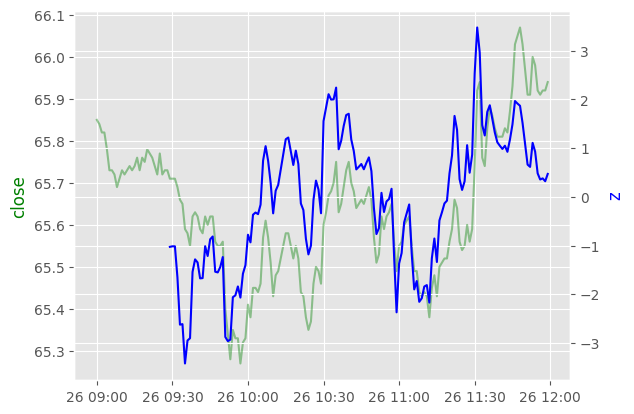

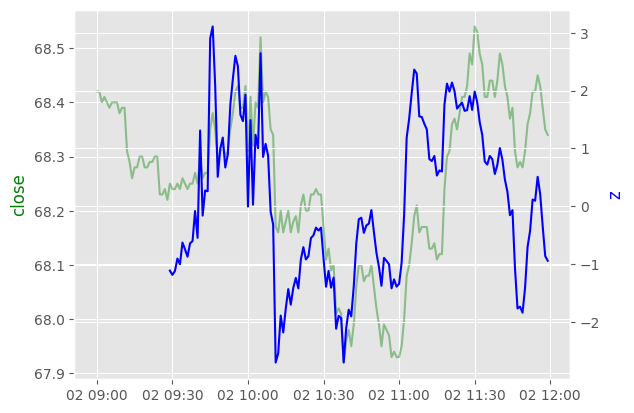

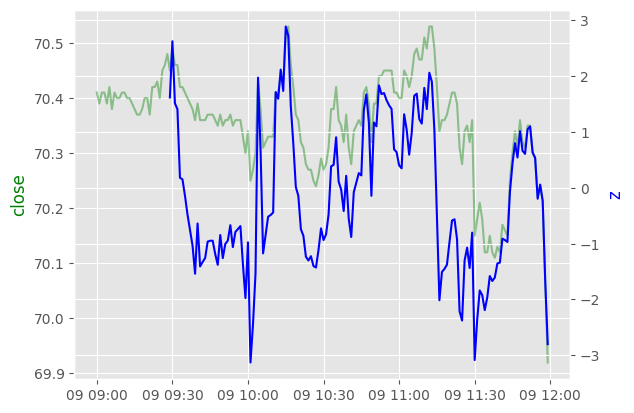

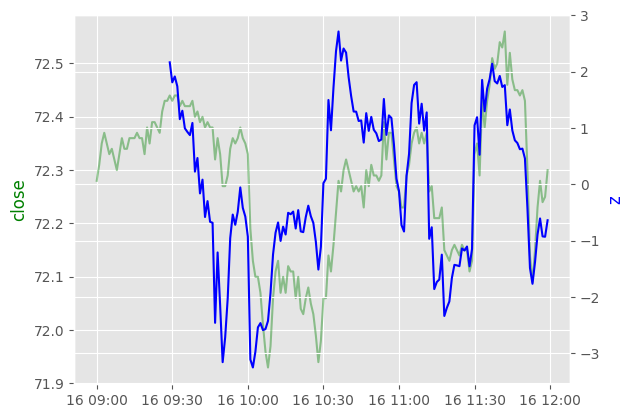

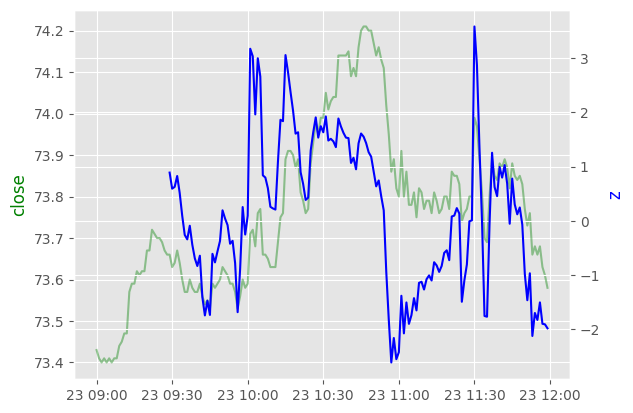

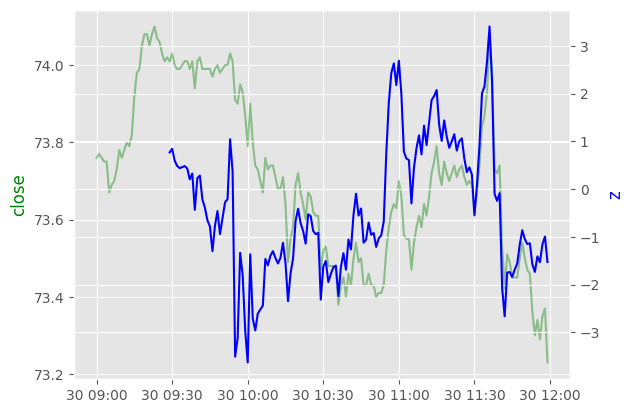

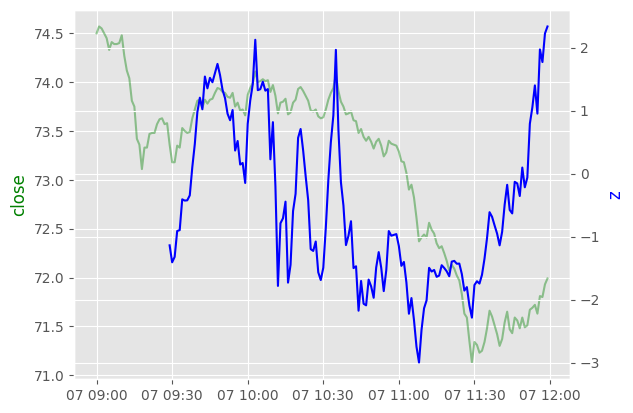

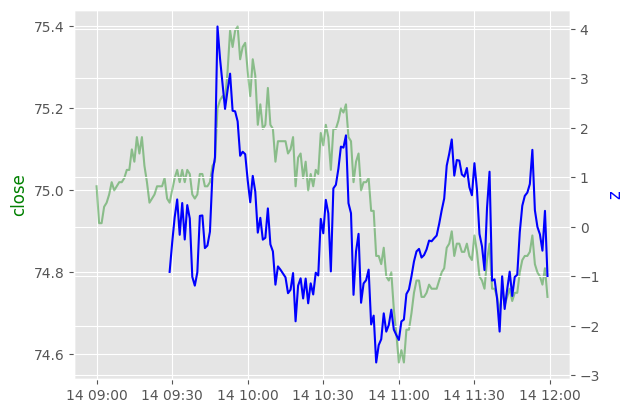

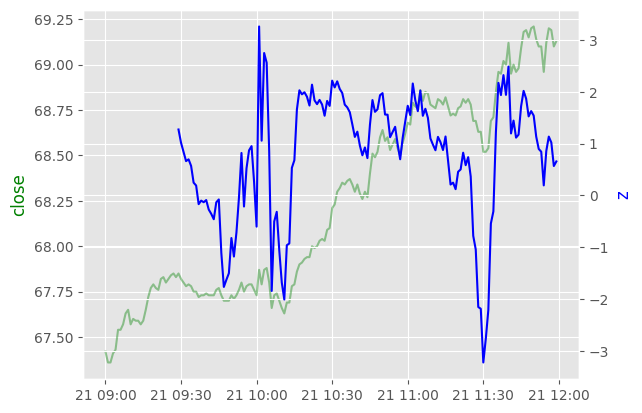

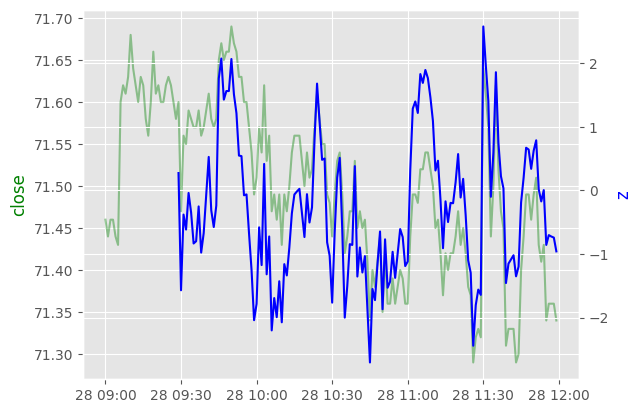

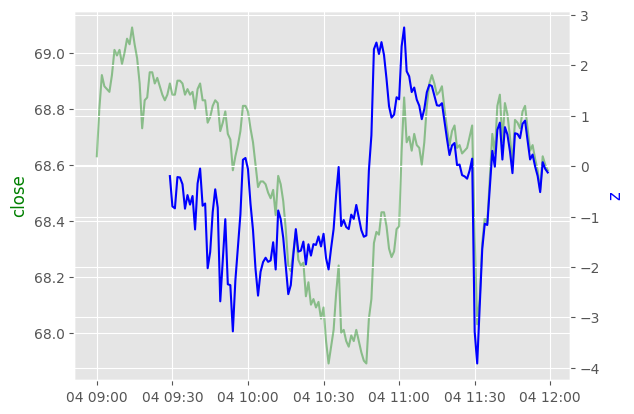

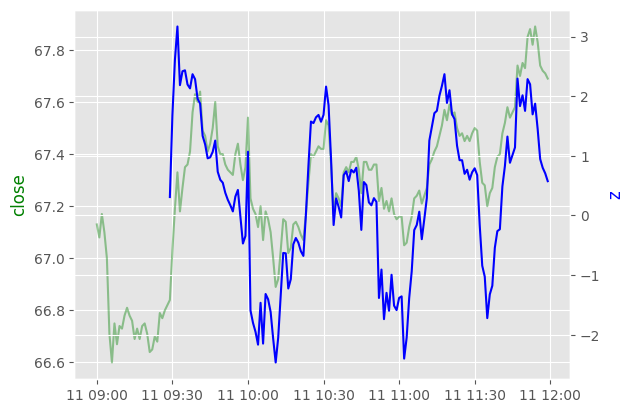

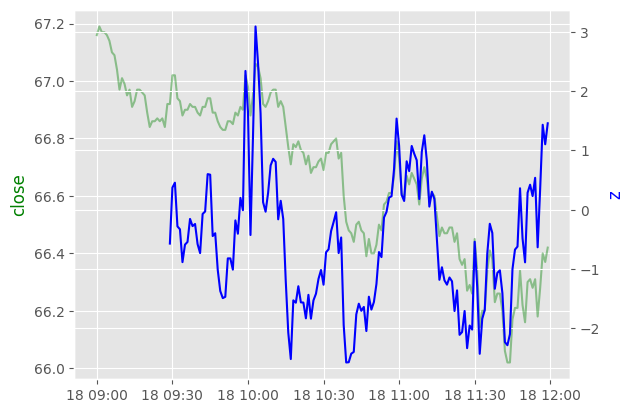

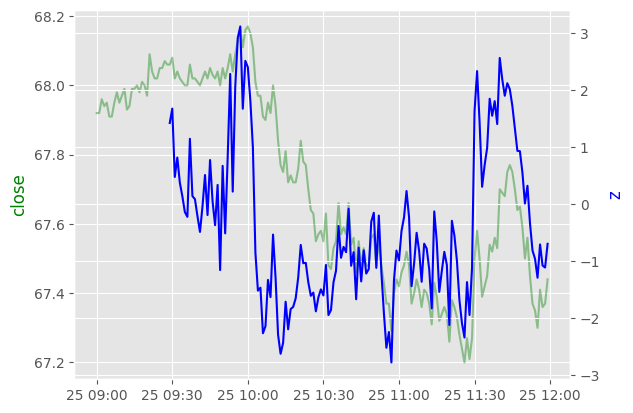

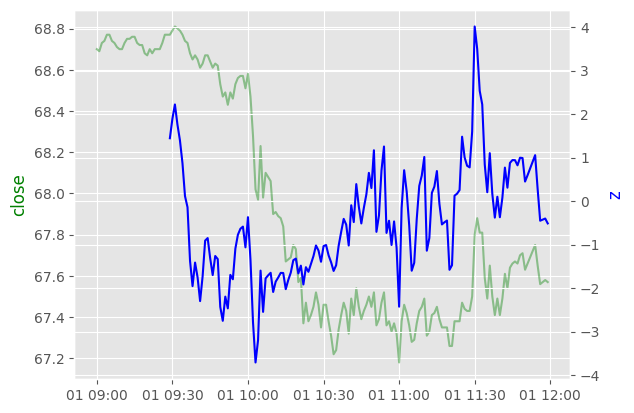

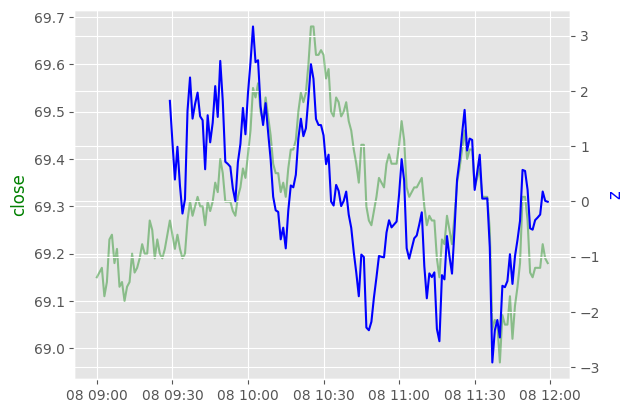

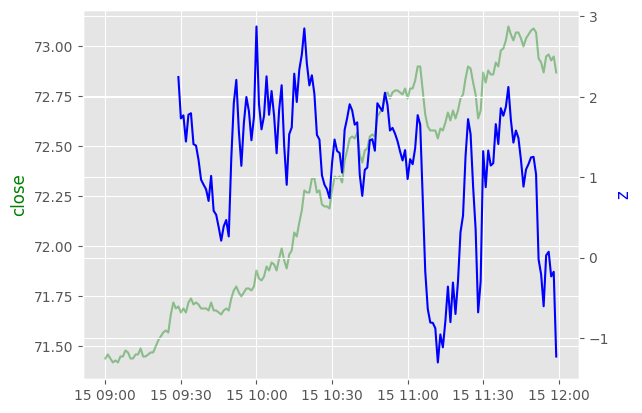

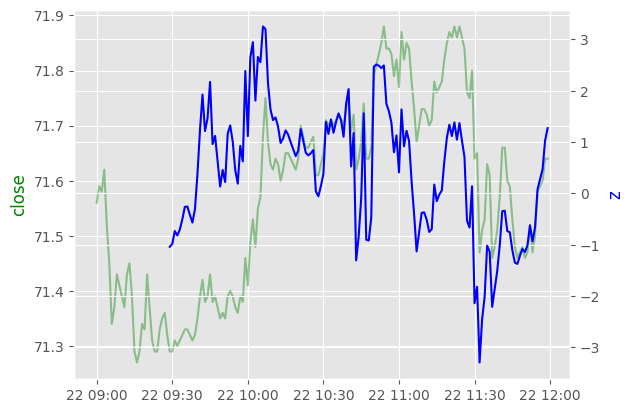

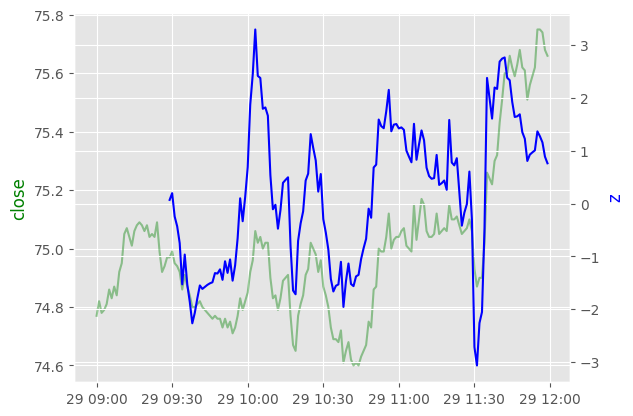

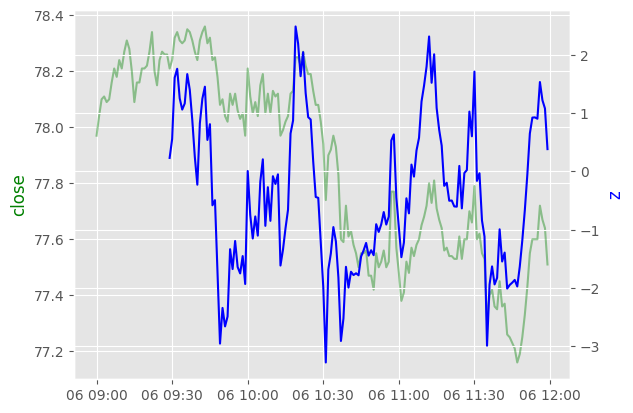

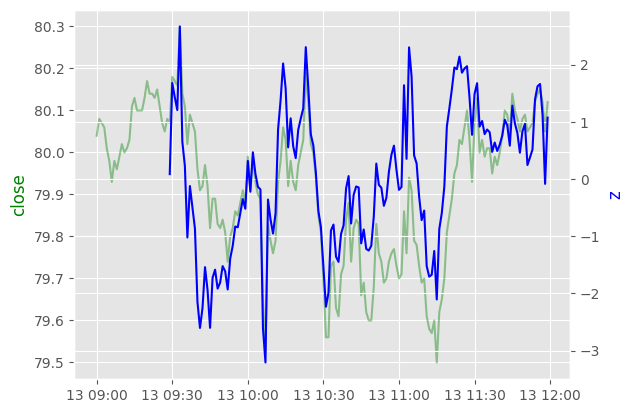

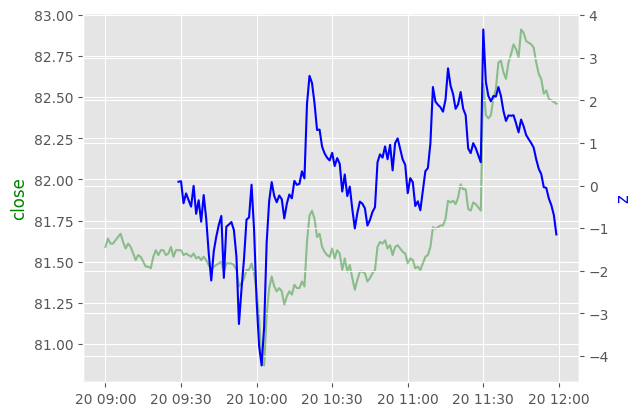

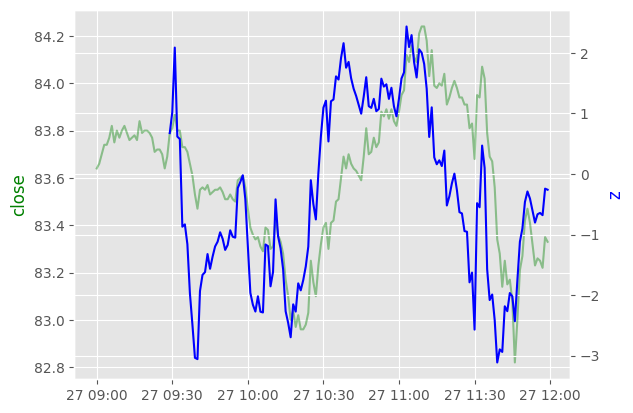

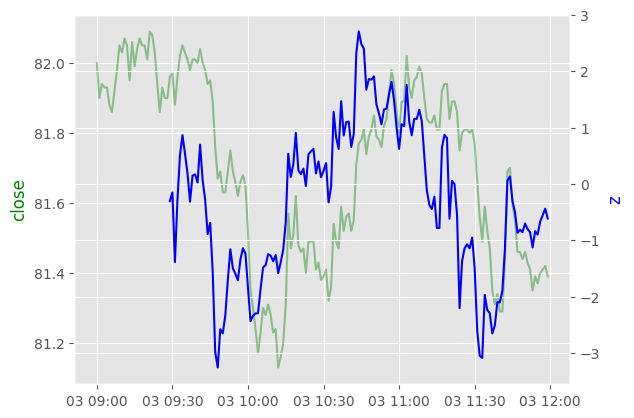

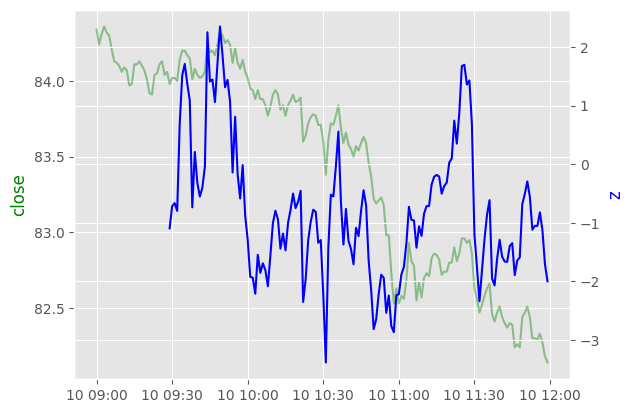

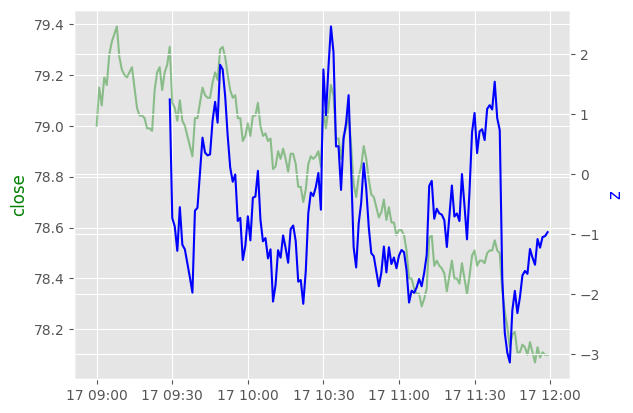

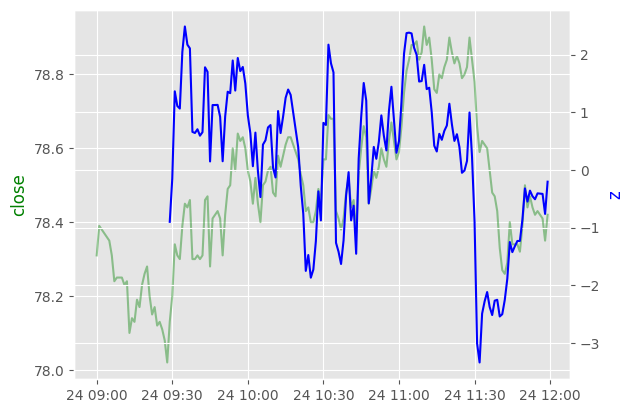

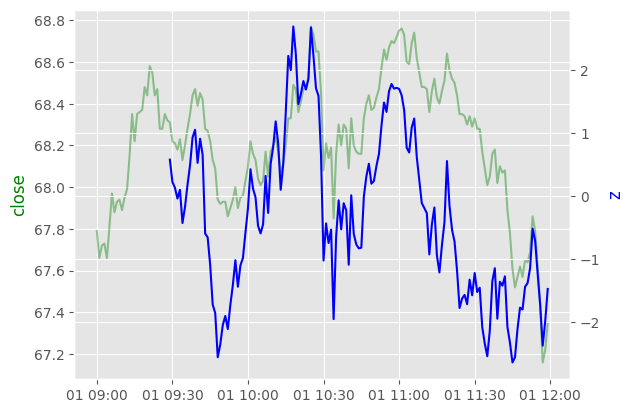

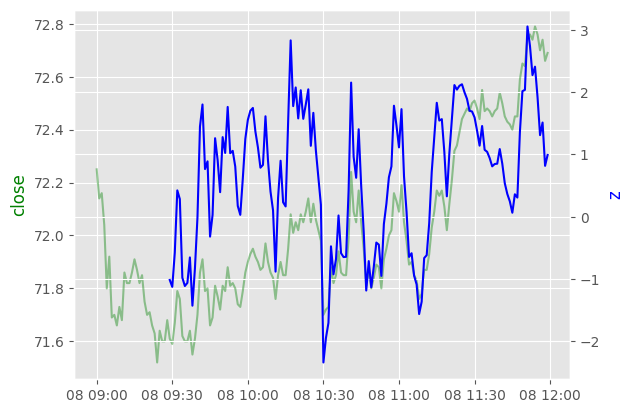

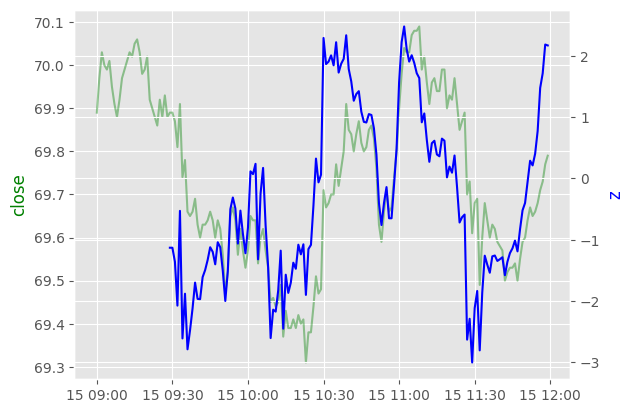

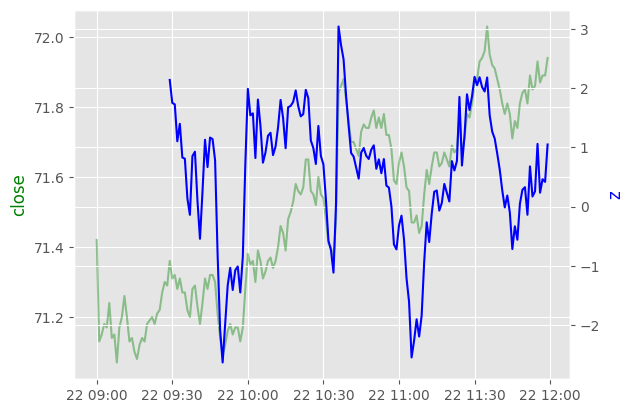

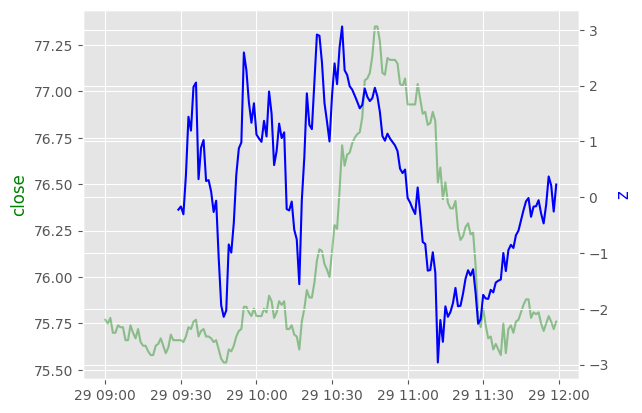

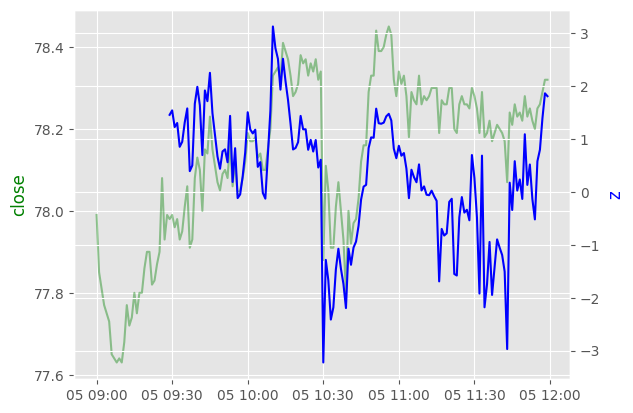

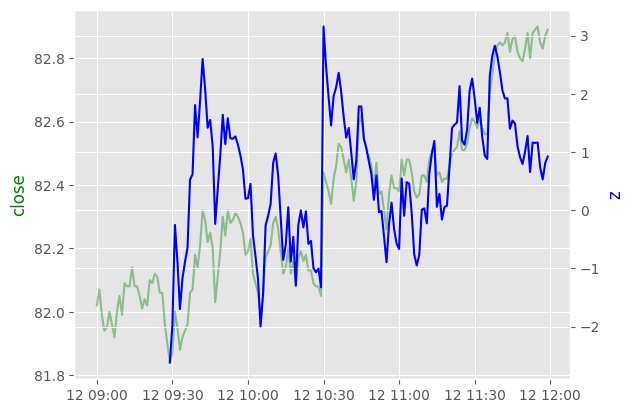

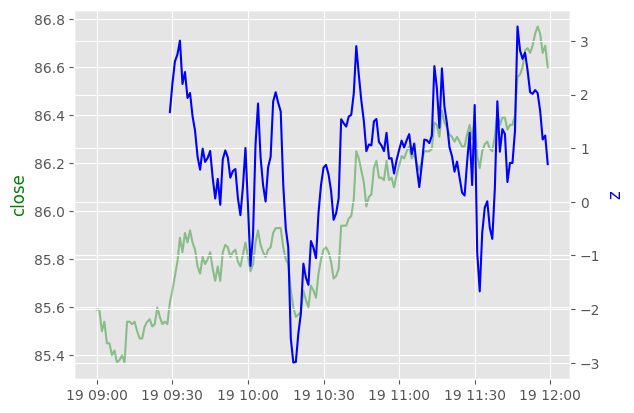

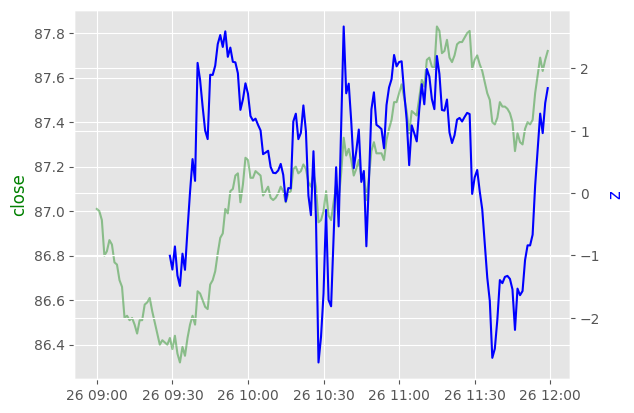

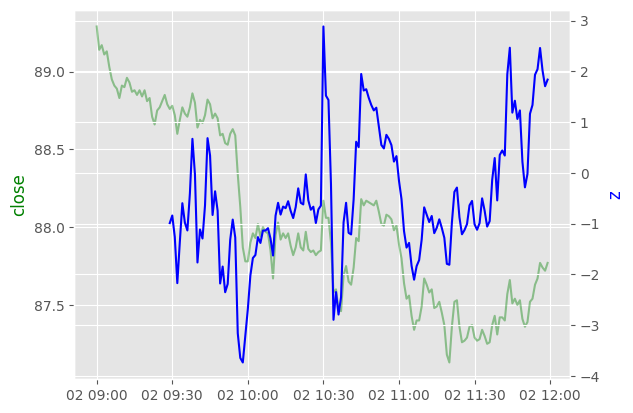

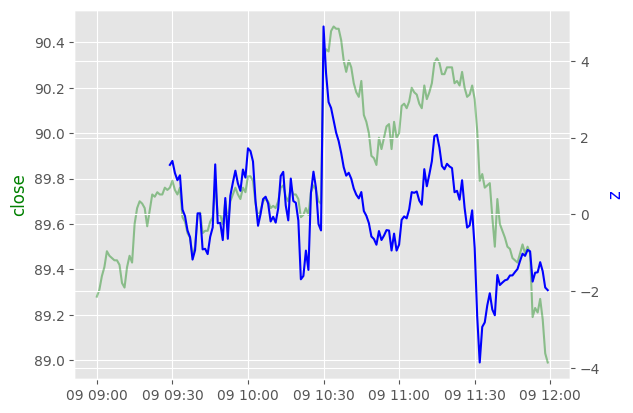

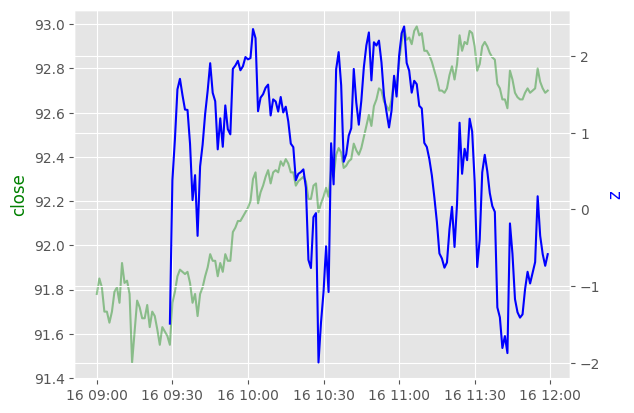

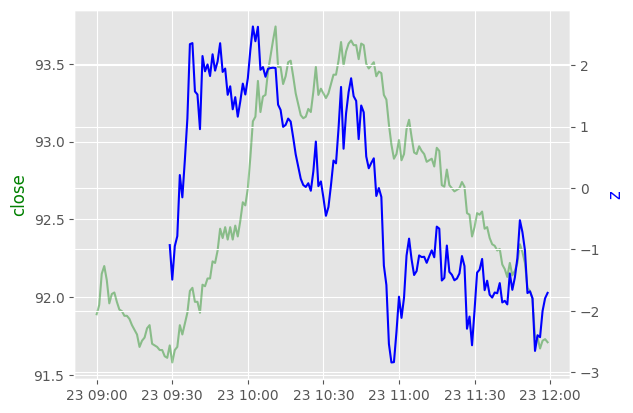

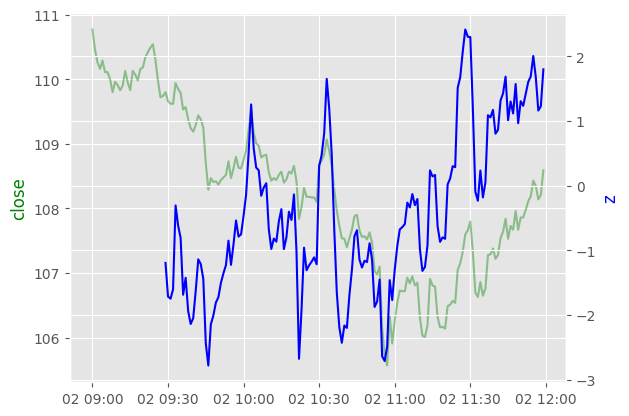

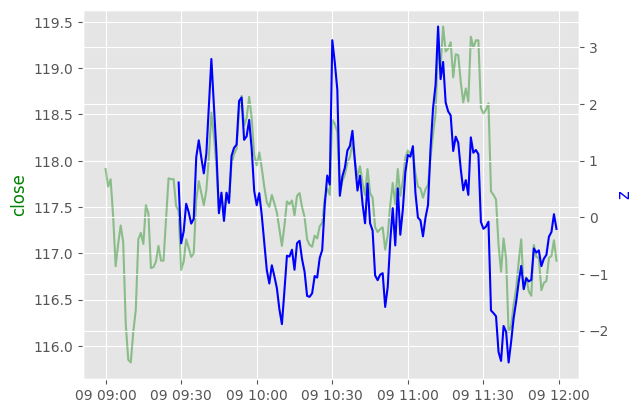

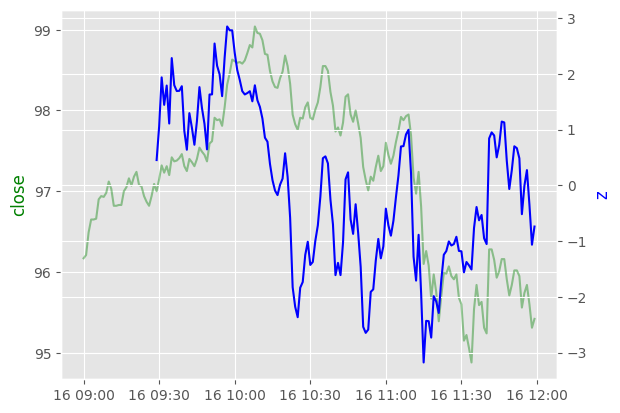

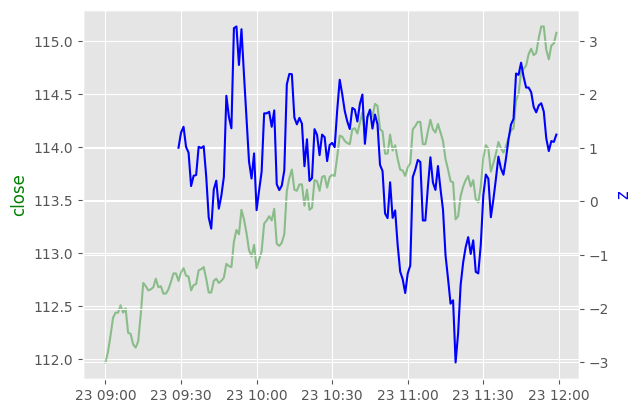

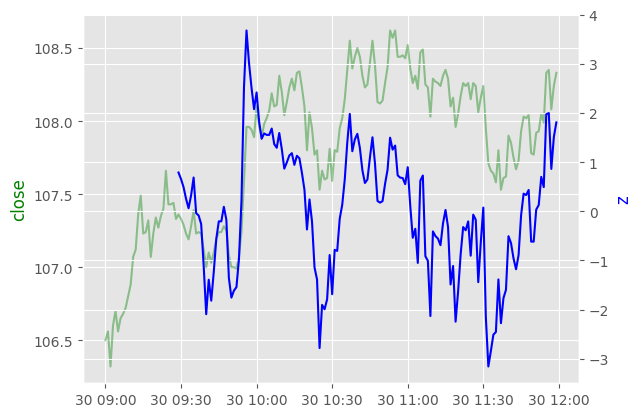

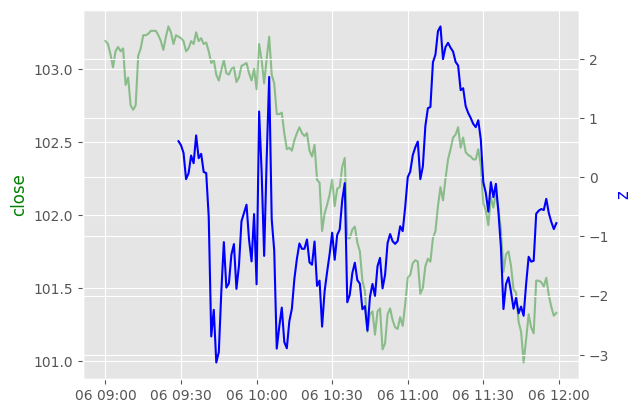

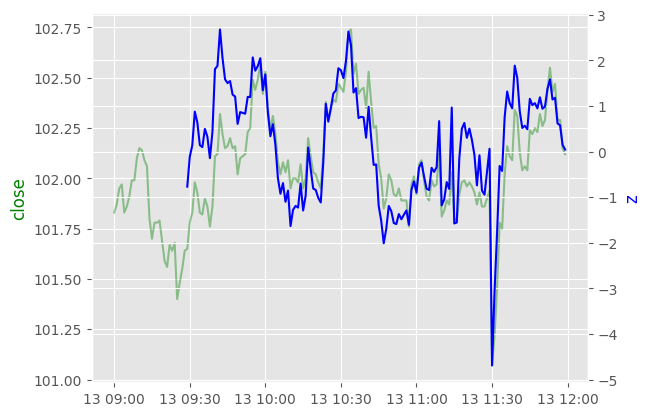

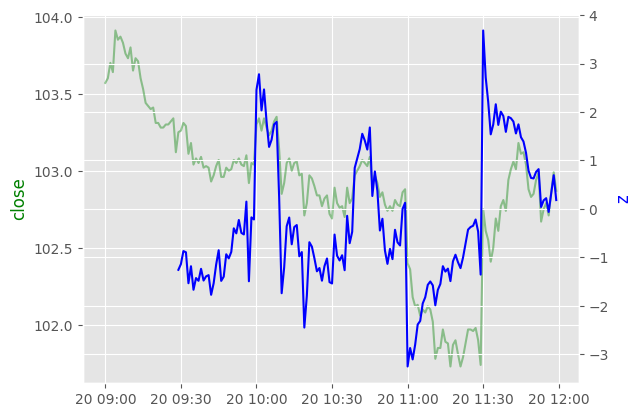

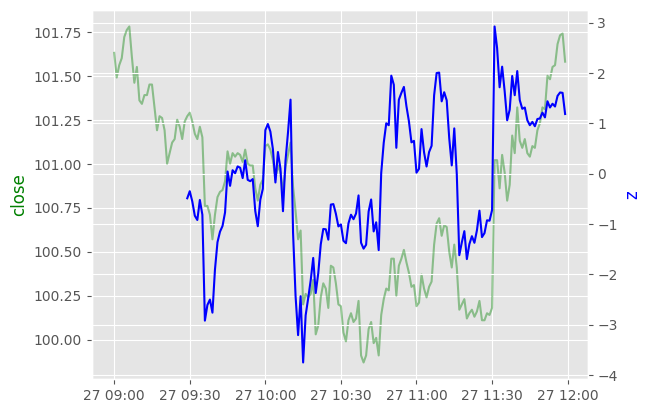

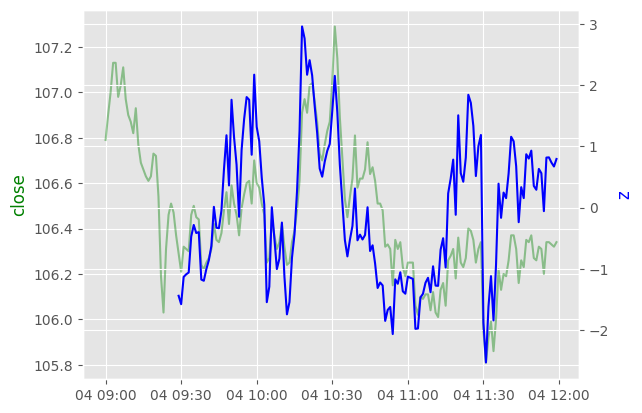

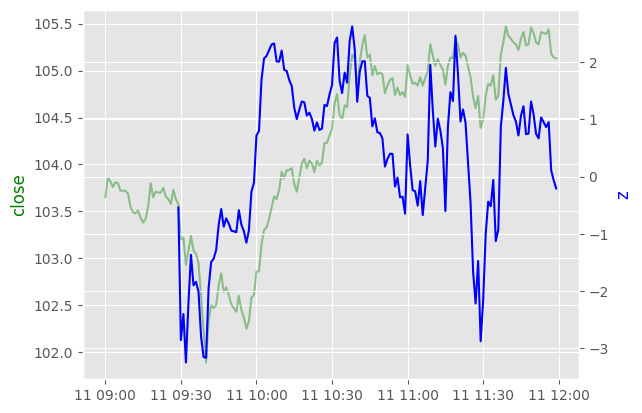

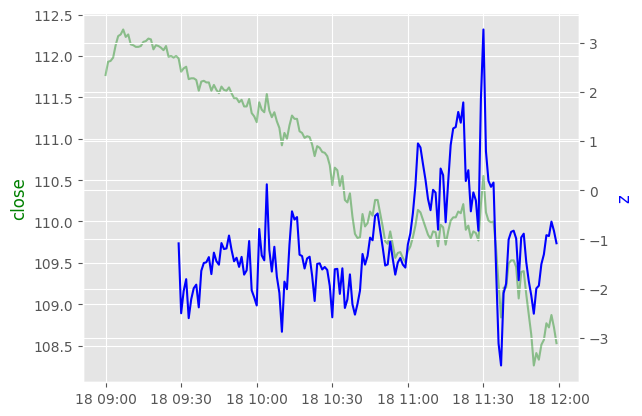

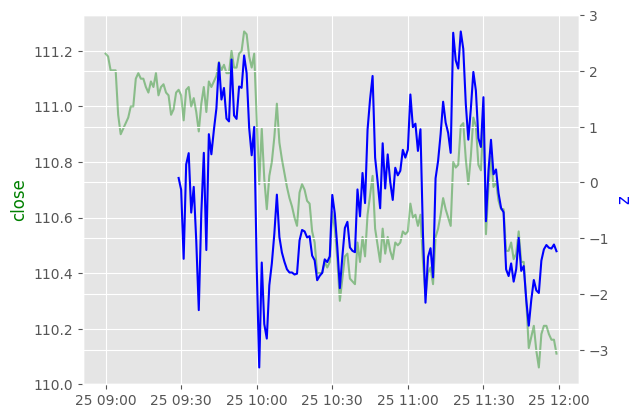

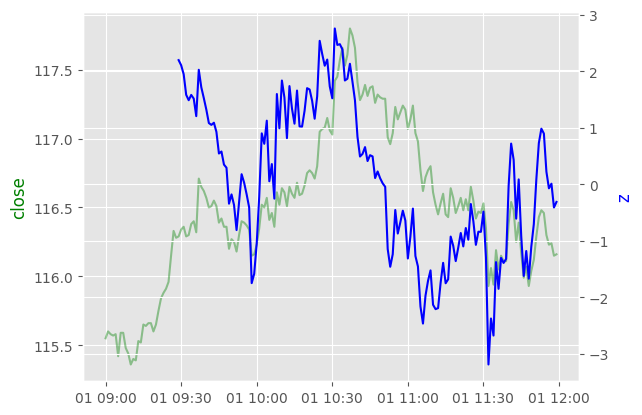

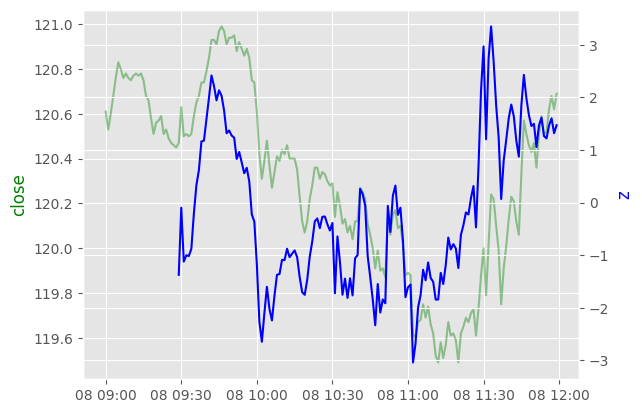

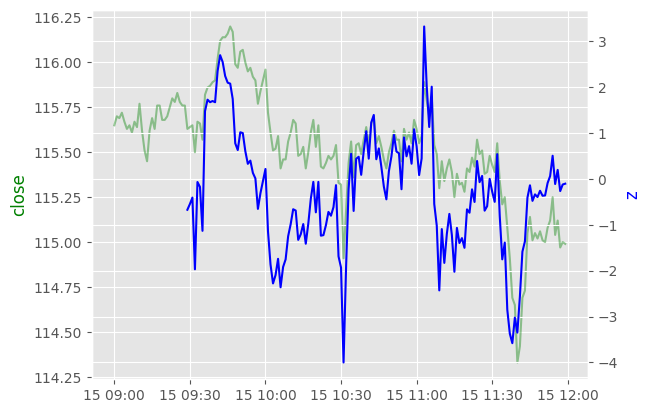

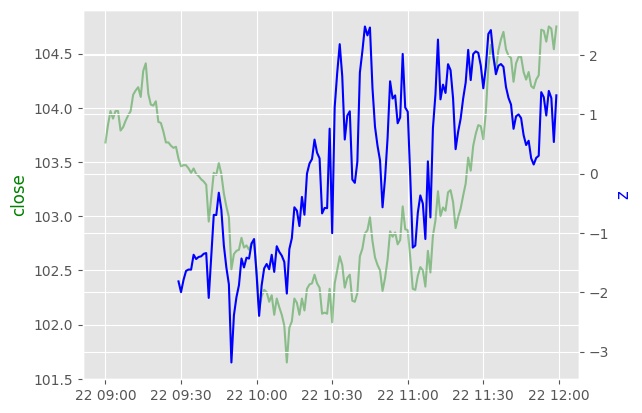

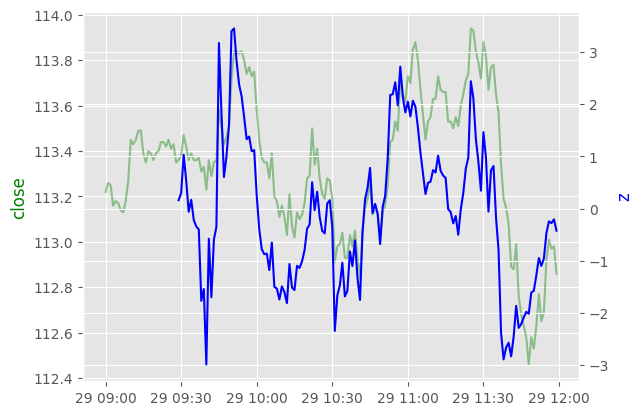

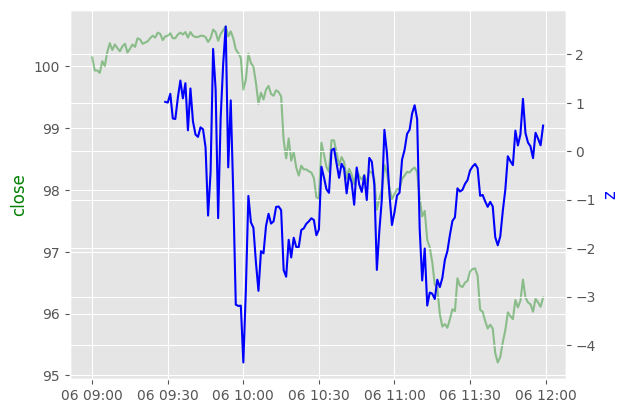

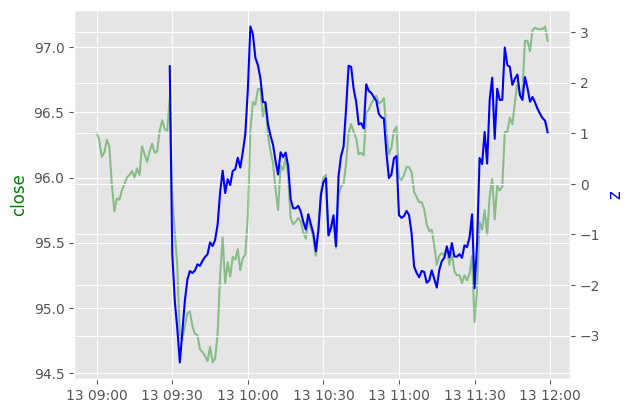

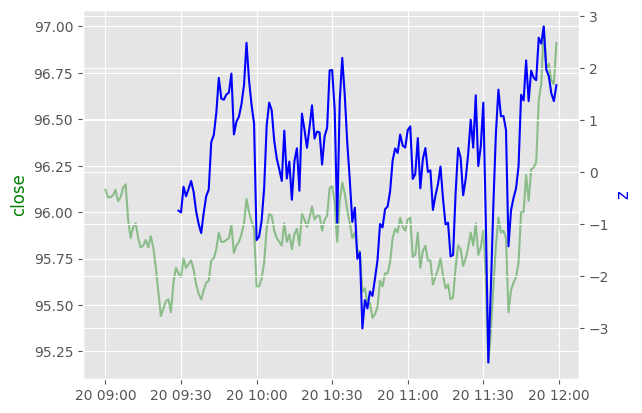

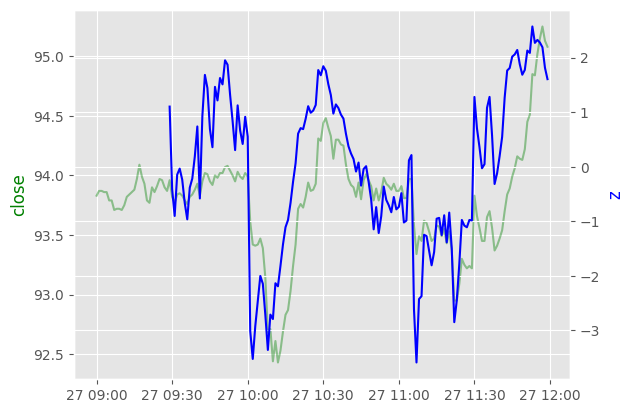

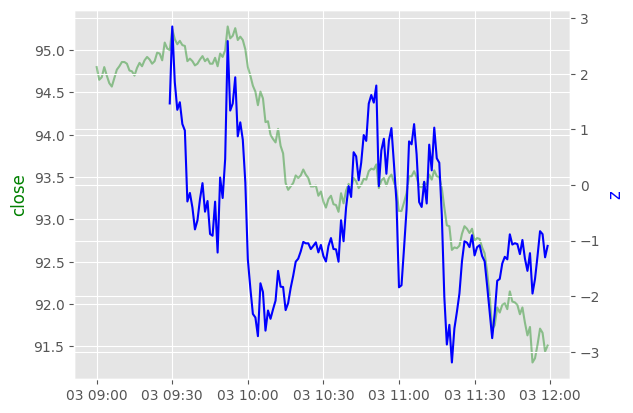

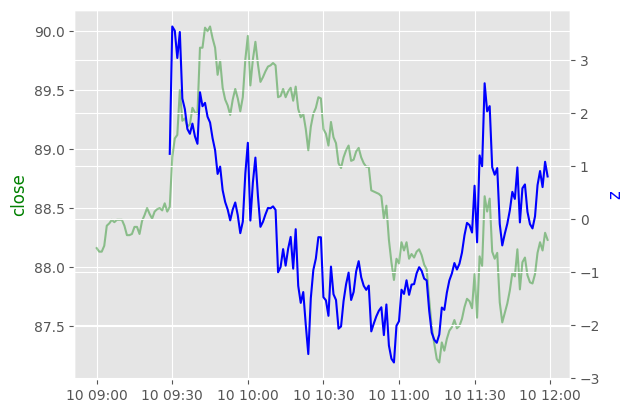

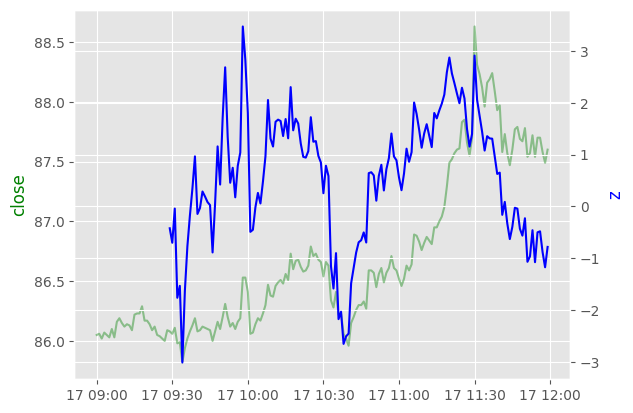

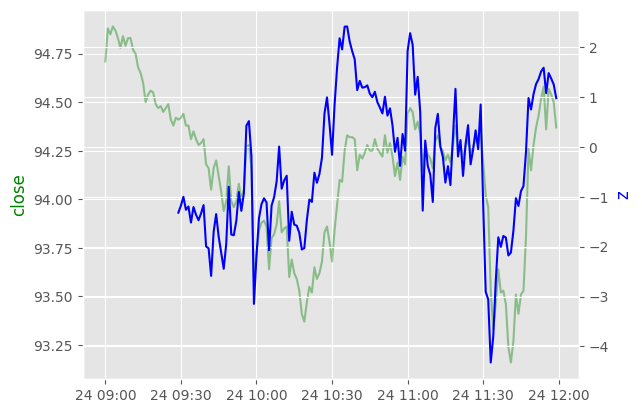

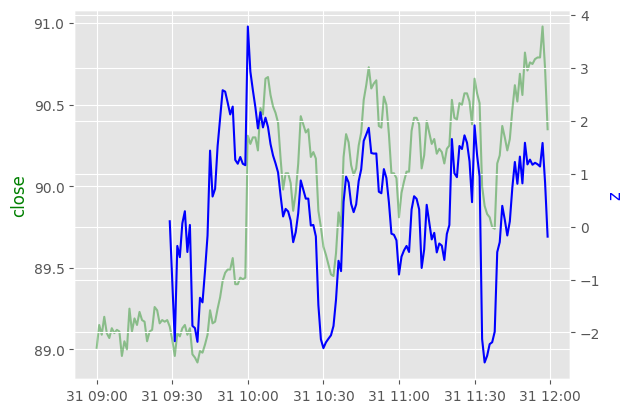

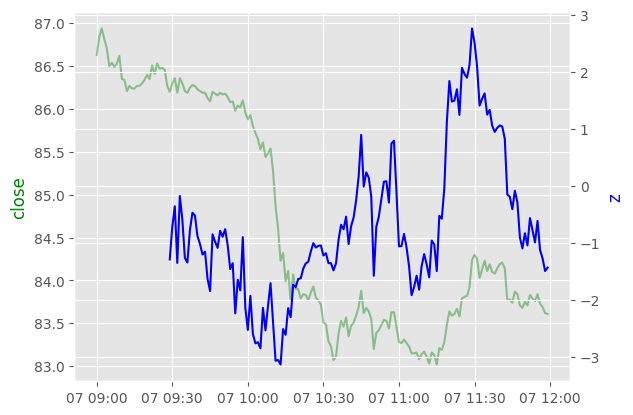

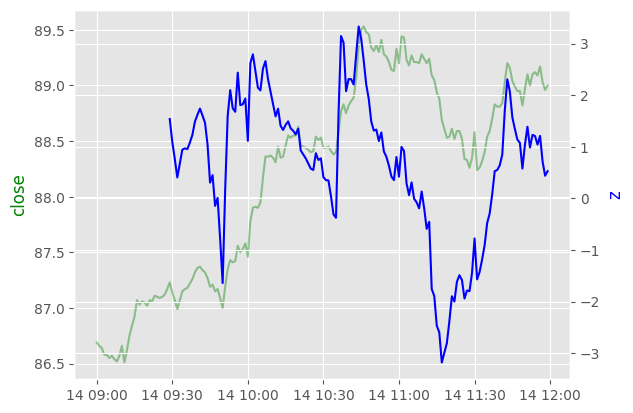

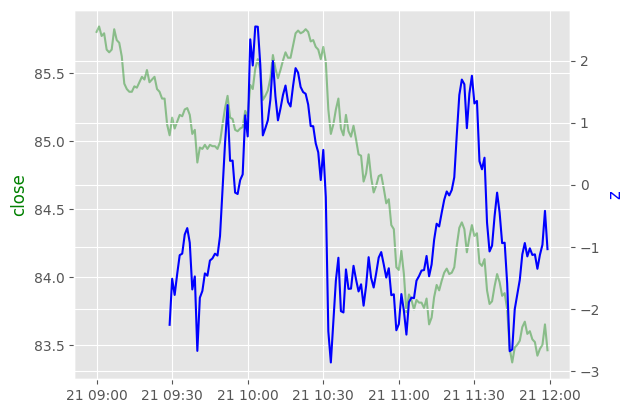

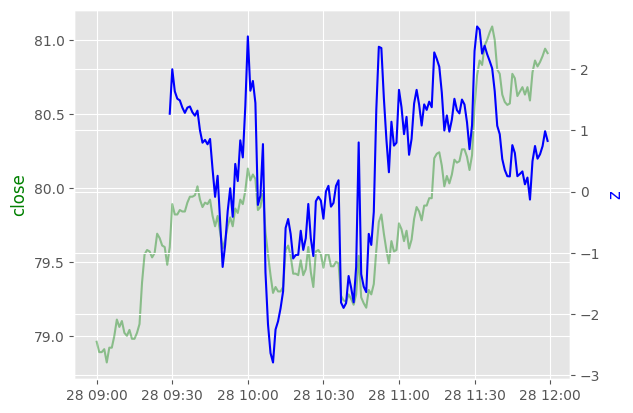

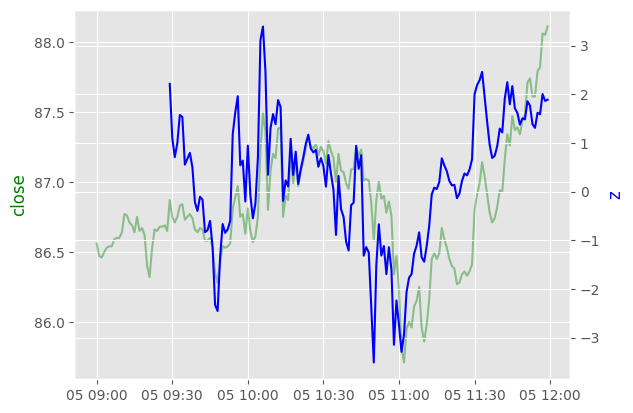

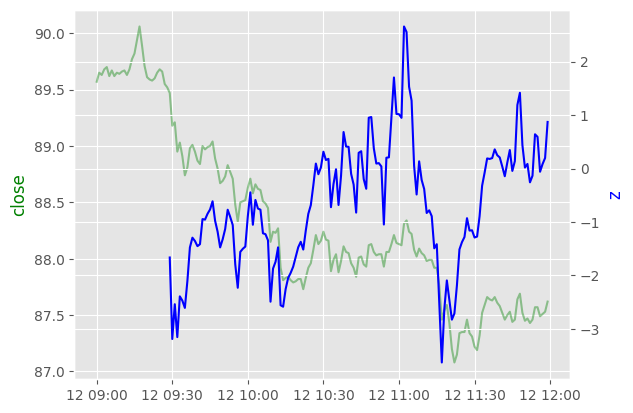

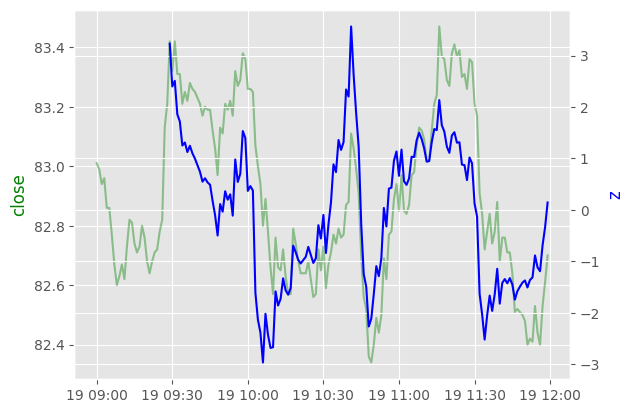

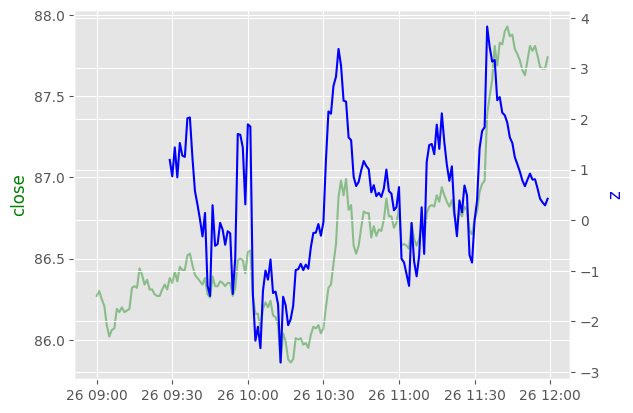

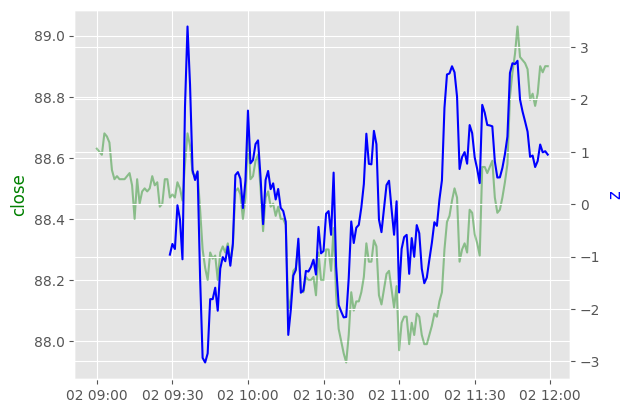

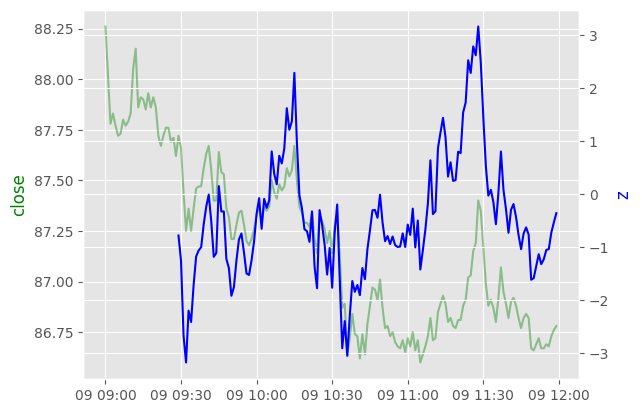

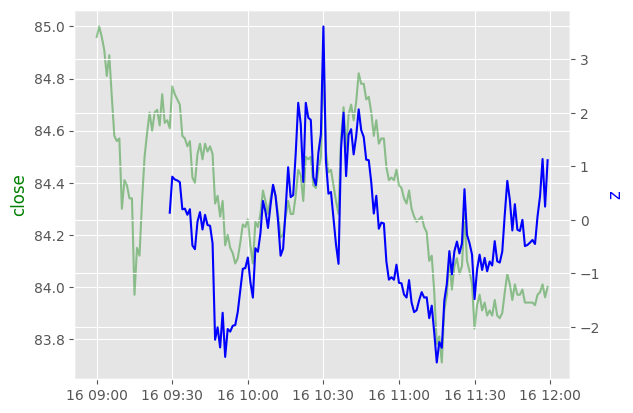

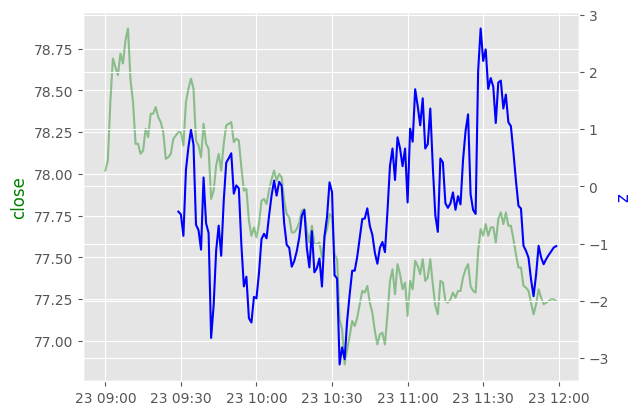

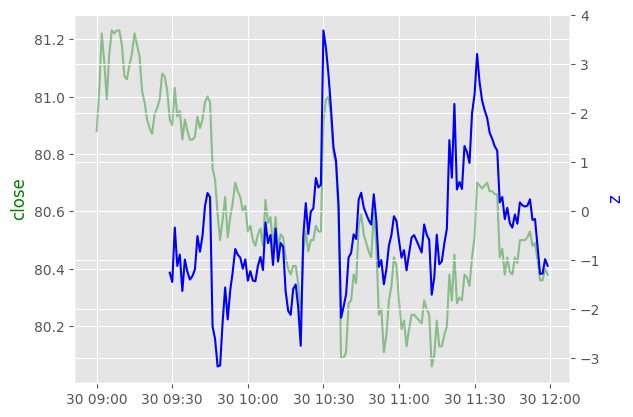

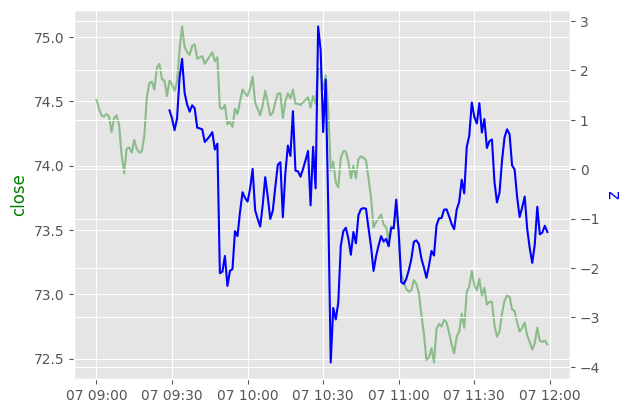

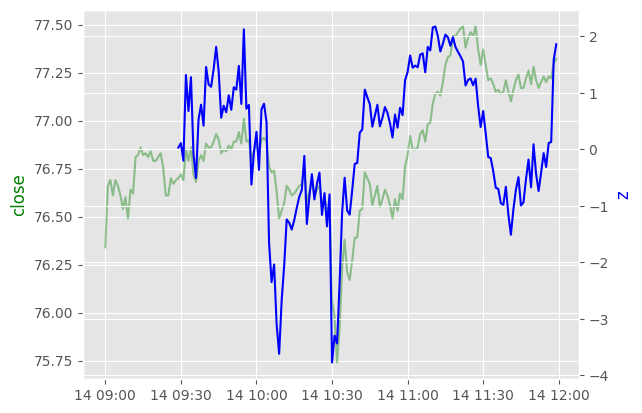

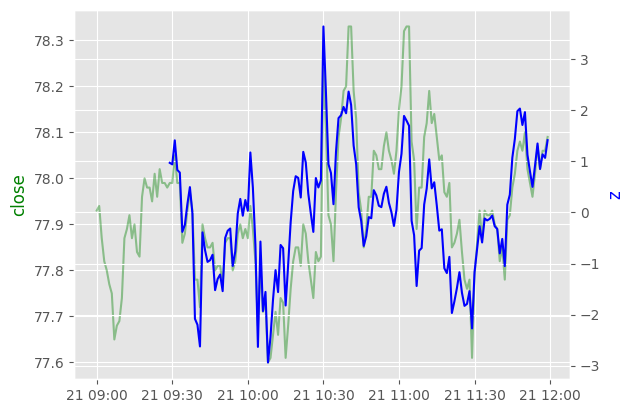

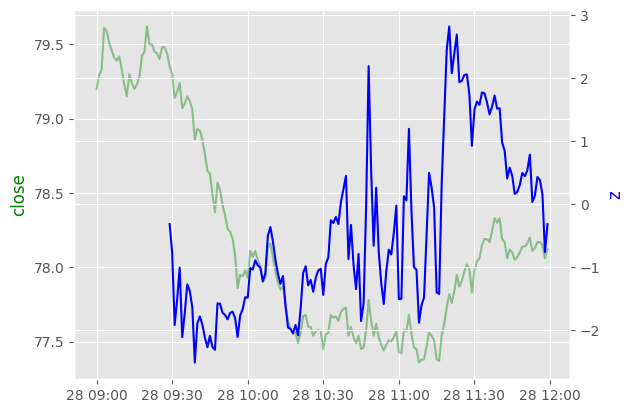

In [12]:
for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
    close = df_day.close
    rolled = close.rolling(window=30).apply(z_score)

    fig, ax1 = plt.subplots()

    ax1.plot(close.index, close, 'g-',  alpha=0.4)
    ax1.set_ylabel('close', color='g')

    ax2 = ax1.twinx()
    ax2.plot(close.index, rolled, 'b-',)
    ax2.set_ylabel('z', color='b')

    plt.show()